In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy
import time
%matplotlib inline
import matplotlib.pyplot as plt

def generate_reconstructions(reconstructions, images=None, input=None):
    reconstructions = reconstructions.view(reconstructions.shape[0], 1, 28, 28)
    reconstructions = reconstructions.detach().numpy()
    reconstructions = reconstructions * 255.
    if images is not None:
      images = images * 255.
    if type(input) == int:
      rows = 5
      columns = 4
      fig, axs = plt.subplots(rows, columns)
      r_sample = 0
      i_sample = 0
      for i in range(0, rows):
        for j in range(0, columns):
              if j % 2 == 0:
                  axs[i,j].imshow(images[i_sample, 0, :, :], cmap="gray")
                  axs[i,j].axis("off")
                  i_sample = i_sample + 1
              else:
                  axs[i,j].imshow(reconstructions[r_sample, 0, :, :], cmap="gray")
                  axs[i,j].axis("off")
                  r_sample = r_sample + 1

      fig.savefig("Reconstructions for Epoch "+str(input)+".png")
      plt.show()
      plt.close()

def squash(tensor, dim=-1):
  squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
  return (squared_norm / (1 + squared_norm)) * (tensor / torch.sqrt(squared_norm))

def softmax(tensor, dim):
  transposed_tensor = tensor.transpose(dim, len(tensor.shape)-1)
  softmaxed_tensor = F.softmax(transposed_tensor.contiguous().view(-1, transposed_tensor.shape[-1]), dim=-1)
  output_tensor = softmaxed_tensor.view(*transposed_tensor.shape).transpose(dim, len(tensor.shape)-1)
  return output_tensor

class CapsLayerOne(nn.Module):
  def __init__(self, num_capsules, in_channels, out_channels, kernel_size, stride):
    super(CapsLayerOne, self).__init__()
    self.capsules = nn.ModuleList([nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=0) for _ in range(num_capsules)])

  def forward(self, x):
    outputs = [capsule(x) for capsule in self.capsules]
    outputs = torch.cat(outputs, dim=-1)
    outputs = outputs.view(outputs.shape[0], outputs.shape[1], -1)
    outputs = outputs.transpose(1, len(outputs.shape)-1)
    outputs = squash(outputs)
    return outputs

class CapsLayerTwo(nn.Module):
  def __init__(self, num_capsules, routing_nodes, in_channels, out_channels, routing_iterations=3):
    super(CapsLayerTwo, self).__init__()
    self.routing_iterations = routing_iterations
    self.weights = torch.randn(num_capsules, routing_nodes, in_channels, out_channels).cuda()

  def forward(self, x):
    x_hat = torch.matmul(x[None, :, :, None, :], self.weights[:, None, :, :, :])  
    b = torch.zeros(*x_hat.shape).cuda()
    for i in range(self.routing_iterations):
      c = softmax(b, dim=2)
      outputs = squash((x_hat*c).sum(dim=2, keepdim=True))
      if i != self.routing_iterations-1:
        db = (x_hat * outputs).sum(dim=-1, keepdim=True)
        b = b + db
    return outputs

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.model = nn.Sequential()

  def build_decoder(self):
    self.model.add_module("linear 1", nn.Linear(160, 512))
    self.model.add_module("relu 1", nn.ReLU())
    self.model.add_module("linear 2", nn.Linear(512, 1024))
    self.model.add_module("relu 2", nn.ReLU())
    self.model.add_module("linear 3", nn.Linear(1024, 784))
    self.model.add_module("relu 3", nn.Sigmoid())
    return self.model

class CapsuleNetwork(nn.Module):
  def __init__(self):
    super(CapsuleNetwork, self).__init__()
    self.conv = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9, stride=1, padding=0)
    self.capslayerone = CapsLayerOne(num_capsules=32, in_channels=256, out_channels=8, kernel_size=9, stride=2)
    self.capslayertwo = CapsLayerTwo(num_capsules=10, routing_nodes=32*6*6, in_channels=8, out_channels=16)
    self.decoder = Decoder().build_decoder()

  def forward(self, x, y=None):
    x = F.relu(self.conv(x), inplace=True)
    x = self.capslayerone(x)
    x = self.capslayertwo(x)
    x = x.squeeze().transpose(0, 1)
    class_scores = torch.sqrt((x**2).sum(dim=-1))
    class_probabilities = F.softmax(class_scores)
    if y is None:
      _, labels = class_probabilities.topk(k=1, dim=1)
      y = torch.eye(10).cuda().index_select(dim=0, index=labels.squeeze())
    reconstructions = self.decoder((x * y[:, :, None]).reshape(x.shape[0], -1))
    return class_probabilities, reconstructions  

class CapsuleLoss(nn.Module):
  def __init__(self):
    super(CapsuleLoss, self).__init__()
    self.reconstruction_loss = nn.MSELoss(size_average=False)
    self.m_positive = 0.9
    self.m_negative = 0.1
    self.lambda_constant = 0.5
    self.alpha_constant = 0.0005

  def forward(self, images, reconstructions, labels, class_probabilities):
    assert torch.numel(images) == torch.numel(reconstructions)
    images = images.view(reconstructions.shape[0], -1)

    margin_loss = (labels * F.relu(self.m_positive - class_probabilities, inplace=True)**2 + self.lambda_constant * (1. - labels) * F.relu(class_probabilities - self.m_negative) ** 2).sum()
    reconstruction_loss = self.reconstruction_loss(images, reconstructions)
    return (margin_loss + self.alpha_constant*reconstruction_loss)/images.shape[0]

/home/harry/anaconda3/envs/capsuleNetwork/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/harry/anaconda3/envs/capsuleNetwork/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


10 % Complete
20 % Complete
30 % Complete
40 % Complete
50 % Complete
60 % Complete
70 % Complete
80 % Complete
90 % Complete
100 % Complete
Epoch 1 / 10:
Time Elapsed = 222 s
Training Loss = 0.519209
Training Accuracy = 93.14 %
10 % Complete
20 % Complete
30 % Complete
40 % Complete
50 % Complete
60 % Complete
70 % Complete
80 % Complete
90 % Complete
100 % Complete
Epoch 2 / 10:
Time Elapsed = 222 s
Training Loss = 0.488958
Training Accuracy = 97.54 %
Generate Reconstructions:
Reconstructions Generated
10 % Complete
20 % Complete
30 % Complete
40 % Complete
50 % Complete
60 % Complete
70 % Complete
80 % Complete
90 % Complete
100 % Complete
Epoch 3 / 10:
Time Elapsed = 226 s
Training Loss = 0.482348
Training Accuracy = 98.17 %
10 % Complete
20 % Complete
30 % Complete
40 % Complete
50 % Complete
60 % Complete
70 % Complete
80 % Complete
90 % Complete
100 % Complete
Epoch 4 / 10:
Time Elapsed = 226 s
Training Loss = 0.478679
Training Accuracy = 98.51 %
10 % Complete
20 % Complete
30 %

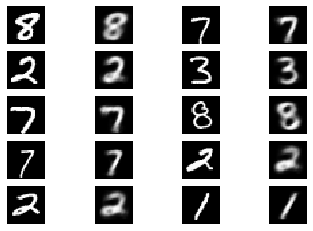

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST("MNIST_data/", transform=transform, download=True, train=True)
testset = datasets.MNIST("MNIST_data/", transform=transform, download=True, train=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

model = CapsuleNetwork()
model.cuda()
optimizer = optim.Adam(model.parameters())
loss_function = CapsuleLoss()
epochs = 10
for epoch in range(epochs):
  start_time = time.time()
  running_loss = 0
  training_accuracy = 0
  count = 0
  percent = 0
  for images, raw_labels in iter(trainloader):
    count += 1
    #print(count)
    labels = torch.eye(10).index_select(dim=0, index=raw_labels)
    class_probabilities, reconstructions = model(images.cuda(), labels.cuda())
    loss = loss_function(images.cuda(), reconstructions, labels.cuda(), class_probabilities)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    _, logits = class_probabilities.topk(k=1, dim=1)
    training_accuracy_tensor = logits.view(*raw_labels.shape) == raw_labels.cuda()
    training_accuracy += torch.mean(training_accuracy_tensor.type(torch.FloatTensor))
    if(count % (int(len(trainloader)/10)+1) == 0):
      percent += 10
      print("%d %% Complete" % (percent))
  percent += 10
  print("%d %% Complete" % (percent))
  training_loss = running_loss / len(trainloader)
  training_accuracy = training_accuracy * 100 / len(trainloader)
  elapsed_time = time.time() - start_time
  print("Epoch %d / %d:" % (epoch+1, epochs))
  print("Time Elapsed = %d s" % (elapsed_time))
  print("Training Loss = %f" % (training_loss))
  print("Training Accuracy = %0.2f %%" % (training_accuracy))
  if (epoch-1) % 10 == 0:
    print("Generate Reconstructions:")
    generate_reconstructions(reconstructions[:10].cpu(), images[:10].cpu(), epoch+1)
    print("Reconstructions Generated")
    

Generate Reconstructions:
Reconstructions Generated


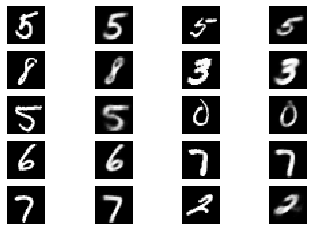

In [3]:
    print("Generate Reconstructions:")
    generate_reconstructions(reconstructions[:10].cpu(), images[:10].cpu(), epoch+1)
    print("Reconstructions Generated")